# Assignment 4 - Neural Networks

# Learning objectives
This assignment is designed to help develop a detailed understanding of the math and practical implementation considerations of neural networks, one of the most widely used machine learning tools, so that it can be leveraged for learning about other neural networks of different model architectures.

## [45 points] Build and test your own Neural Network for classification

There is no better way to understand how one of the core techniques of modern machine learning works than to build a simple version of it yourself. In this exercise you will construct and apply your own neural network classifier. You may use numpy if you wish but no other libraries.

**(a)** Create a neural network class that follows the `scikit-learn` classifier convention by implementing `fit`, `predict`, and `predict_proba` methods. Your `fit` method should run backpropagation on your training data using stochastic gradient descent. Assume the activation function is a sigmoid. Choose your model architecture to have two input nodes, two hidden layers with five nodes each, and one output node.

To guide you in the right direction with this problem, please find a skeleton of a neural network class below. You absolutely MAY use additional methods beyond those suggested in this template, but the methods listed below are the minimum required to implement the model cleanly.

**Strategies for debugging**. One of the greatest challenges of this implementations is that there are many parts and a bug could be present in any of them. Here are some recommended tips:
- *Development environment*. Consider using an Integrated Development Environment (IDE). I strongly recommend the use of VS Code and the Python debugging tools in that development environment.
- *Unit tests*. You are strongly encouraged to create unit tests for most modules. Without doing this will make your code extremely difficult to bug. You can create simple examples to feed through the network to validate it is correctly computing activations and node values. Also, if you manually set the weights of the model, you can even calculate backpropagation by hand for some simple examples (admittedly, that unit test would be challenging and is optional, but a unit test is possible). 
- *Compare against a similar architecture*. You can also verify the performance of your overall neural network by comparing it against the `scikit-learn` implementation and using the same architecture and parameters as your model (your model outputs will certainly not be identical, but they should be somewhat similar for similar parameter settings).

**(b)** Apply your neural network. 
- Create a training and validation dataset using `sklearn.datasets.make_moons(N, noise=0.20)`, where $N_{train} = 500$ and $N_{test} = 100$. 
- Train and test your model on this dataset plotting your learning curves (training and validation error for each epoch of stochastic gradient descent, where an epoch represents having trained on each of the training samples one time). 
- Tune the learning rate and number of training epochs for your model to improve performance as needed. 
- In two subplots, plot the training data on one subplot, and the validation data on the other subplot. On each plot, also plot the decision boundary from your neural network trained on the training data. 
- Report your performance on the test data with an ROC curve and compare against the `scikit-learn` `MLPClassifier` trained with the same parameters.

**(c)** Suggest two ways in which you neural network implementation could be improved: are there any options we discussed in class that were not included in your implementation that could improve performance?

**ANSWER**

**(a)**

In [ ]:
# Importing libraries
import numpy as np
from sklearn.model_selection import PredefinedSplit
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    auc,
    log_loss,
    f1_score,
    precision_recall_curve,
    average_precision_score,
    plot_roc_curve,
)
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
import sklearn.datasets as skdata

from matplotlib.colors import ListedColormap


In [15]:
np.random.seed(8642)


class myNeuralNetwork(object):
    def __init__(self, n_in, n_layer1, n_layer2, n_out, learning_rate=0.01):
        """__init__
        Class constructor: Initialize the parameters of the network including
        the learning rate, layer sizes, and each of the parameters
        of the model (weights, placeholders for activations, inputs,
        deltas for gradients, and weight gradients). This method
        should also initialize the weights of your model randomly
            Input:
                n_in:          number of inputs
                n_layer1:      number of nodes in layer 1
                n_layer2:      number of nodes in layer 2
                n_out:         number of output nodes
                learning_rate: learning rate for gradient descent
            Output:
                none
        """
        self.n_in = n_in
        self.n_layer1 = n_layer1
        self.n_layer2 = n_layer2
        self.n_out = n_out
        self.learning_rate = learning_rate

        # Initialize weights
        self.w1 = np.random.randn(self.n_layer1, self.n_in)
        self.w2 = np.random.randn(self.n_layer2, self.n_layer1)
        self.w3 = np.random.randn(self.n_out, self.n_layer2)

        # Initialize placeholders for activations and deltas

        self.a1 = np.empty((self.n_layer1, 1))
        self.a2 = np.empty((self.n_layer2, 1))
        self.a3 = np.empty((self.n_out, 1))

        self.delta1 = np.empty((self.n_layer1, 1))
        self.delta2 = np.empty((self.n_layer2, 1))
        self.delta3 = np.empty((self.n_out, 1))

        self.dw1 = np.empty((self.n_layer1, self.n_in))
        self.dw2 = np.empty((self.n_layer2, self.n_layer1))
        self.dw3 = np.empty((self.n_out, self.n_layer2))

    def forward_propagation(self, x):
        """forward_propagation
        Takes a vector of your input data (one sample) and feeds
        it forward through the neural network, calculating activations and
        layer node values along the way.
            Input:
                x: a vector of data representing 1 sample [n_in x 1]
            Output:
                y_hat: a vector (or scaler of predictions) [n_out x 1]
                (typically n_out will be 1 for binary classification)
        """
        # Calculate activations
        self.a1 = self.w1 @ x
        self.a2 = self.w2 @ self.sigmoid(self.a1)
        self.a3 = self.w3 @ self.sigmoid(self.a2)
        y_hat = self.sigmoid(self.a3)

        return y_hat

    def compute_loss(self, X, y):
        """compute_loss
        Computes the current loss/cost function of the neural network
        based on the weights and the data input into this function.
        To do so, it runs the X data through the network to generate
        predictions, then compares it to the target variable y using
        the cost/loss function
            Input:
                X: A matrix of N samples of data [N x n_in]
                y: Target variable [N x 1]
            Output:
                loss: a scalar measure of loss/cost
        """
        # Forward propagation
        y_hat = self.forward_propagation(X)
        loss = -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
        return loss

    def backpropagate(self, x, y):
        """backpropagate
        Backpropagate the error from one sample determining the gradients
        with respect to each of the weights in the network. The steps for
        this algorithm are:
            1. Run a forward pass of the model to get the activations
               Corresponding to x and get the loss function of the model
               predictions compared to the target variable y
            2. Compute the deltas (see lecture notes) and values of the
               gradient with respect to each weight in each layer moving
               backwards through the network

            Input:
                x: A vector of 1 samples of data [n_in x 1]
                y: Target variable [scalar]
            Output:
                loss: a scalar measure of th loss/cost associated with x,y
                      and the current model weights
        """
        # Forward propagation
        y_hat = self.forward_propagation(x)
        loss = self.compute_loss(x, y)

        # Backward propagation
        # self.delta3 = y_hat - y

        self.delta3 = np.multiply(
            (-y / y_hat + (1 - y) / (1 - y_hat)), self.sigmoid_derivative(self.a3)
        )
        self.dw3 = self.delta3 @ self.sigmoid(self.a2).reshape(self.n_layer2, 1).T

        self.delta2 = np.multiply(
            self.w3.T @ self.delta3, self.sigmoid_derivative(self.a2)
        )
        self.dw2 = self.delta2 @ self.sigmoid(self.a1).T

        self.delta1 = np.multiply(
            self.w2.T @ self.delta2, self.sigmoid_derivative(self.a1)
        )
        self.dw1 = self.delta1.reshape(-1, 1) @ x.reshape(-1, 1).T

        return loss, self.w1, self.w2, self.w3

    def stochastic_gradient_descent_step(self):
        """stochastic_gradient_descent_step
        Using the gradient values computed by backpropagate, update each
        weight value of the model according to the familiar stochastic
        gradient descent update equation.

        Input: none
        Output: none
        """
        # Update weights
        self.w1 -= self.learning_rate * self.dw1
        self.w2 -= self.learning_rate * self.dw2
        self.w3 -= self.learning_rate * self.dw3
        pass

    def fit(
        self,
        X_tr,
        y_tr,
        X_val,
        y_val,
        max_epochs=10,
        get_validation_loss=False,
        verbose=False,
    ):
        """fit
        Input:
            X: A matrix of N samples of training data [N x n_in]
            y: Target variable corresponding to training data [N x 1]
            X_val: A matrix of validation data [N x n_in]
            y_val: Target variable corresponding to validation data [N x 1]
        Output:
            training_loss:   Vector of training loss values at the end of each epoch
            validation_loss: Vector of validation loss values at the end of each epoch
                             [optional output if get_validation_loss==True]
        """
        # Initialize training and validation loss vectors
        training_loss = np.empty(max_epochs)

        if get_validation_loss:
            validation_loss = np.empty(max_epochs)

            # Splitting into training and validation sets
            # mask  = np.random.rand(X.shape[0]) < 0.8
            # X_tr = X[mask]
            # y_tr = y[mask]
            # X_val = X[~mask]
            # y_val = y[~mask]

            if verbose:
                print(
                    "Training on {} samples, validating on {} samples".format(
                        X_tr.shape[0], X_val.shape[0]
                    )
                )
        else:
            if verbose:
                print("Training on {} samples".format(X_tr.shape[0]))

        # Setting seed here again to reproduce shuffles
        np.random.seed(209)
        # Training loop
        for epoch in range(max_epochs):
            # Shuffle training data
            idx = np.random.permutation(X_tr.shape[0])
            X_tr = X_tr[idx]
            y_tr = y_tr[idx]

            temp_tr_loss = np.empty(X_tr.shape[0])

            # Stochastic gradient descent step
            for i in range(X_tr.shape[0]):
                loss, self.w1, self.w2, self.w3 = self.backpropagate(X_tr[i], y_tr[i])
                temp_tr_loss[i] = loss
                self.stochastic_gradient_descent_step()

            # Compute training and validation loss
            training_loss[epoch] = np.sum(temp_tr_loss) / X_tr.shape[0]

            if get_validation_loss:
                temp_val_loss = np.empty(X_val.shape[0])
                for i in range(X_val.shape[0]):
                    temp_val_loss[i] = self.compute_loss(X_val[i], y_val[i])
                validation_loss[epoch] = np.sum(temp_val_loss) / X_val.shape[0]

            # Print progress
            if verbose:
                print(
                    "Epoch {}/{}: training loss = {:.4f}".format(
                        epoch + 1, max_epochs, training_loss[epoch]
                    )
                )
                if get_validation_loss:
                    print(
                        "Epoch {}/{}: validation loss = {:.4f}".format(
                            epoch + 1, max_epochs, validation_loss[epoch]
                        )
                    )

        # Return training and validation loss
        if get_validation_loss:
            return training_loss, validation_loss
        else:
            return training_loss

    def predict_proba(self, X):
        """predict_proba
        Compute the output of the neural network for each sample in X, with the last layer's
        sigmoid activation providing an estimate of the target output between 0 and 1
            Input:
                X: A matrix of N samples of data [N x n_in]
            Output:
                y_hat: A vector of class predictions between 0 and 1 [N x 1]
        """
        y_hat = np.empty((X.shape[0], 1))
        # Forward propagation
        for i in range(X.shape[0]):
            y_i = self.forward_propagation(X[i])
            y_hat[i] = y_i[0]
        return y_hat

    def predict(self, X, decision_thresh=0.5):
        """predict
        Compute the output of the neural network prediction for
        each sample in X, with the last layer's sigmoid activation
        providing an estimate of the target output between 0 and 1,
        then thresholding that prediction based on decision_thresh
        to produce a binary class prediction
            Input:
                X: A matrix of N samples of data [N x n_in]
                decision_threshold: threshold for the class confidence score
                                    of predict_proba for binarizing the output
            Output:
                y_hat: A vector of class predictions of either 0 or 1 [N x 1]
        """
        y_hat = np.empty((X.shape[0], 1))
        # Forward propagation
        for i in range(X.shape[0]):
            y_i = self.forward_propagation(X[i])
            y_i = np.where(y_i > decision_thresh, 1, 0)
            y_hat[i] = y_i[0]
        return y_hat

    def sigmoid(self, X):
        """sigmoid
        Compute the sigmoid function for each value in matrix X
            Input:
                X: A matrix of any size [m x n]
            Output:
                X_sigmoid: A matrix [m x n] where each entry corresponds to the
                           entry of X after applying the sigmoid function
        """
        return 1 / (1 + np.exp(-X))

    def sigmoid_derivative(self, X):
        """sigmoid_derivative
        Compute the sigmoid derivative function for each value in matrix X
            Input:
                X: A matrix of any size [m x n]
            Output:
                X_sigmoid: A matrix [m x n] where each entry corresponds to the
                           entry of X after applying the sigmoid derivative function
        """
        return self.sigmoid(X) * (1 - self.sigmoid(X))


In [16]:
# Writing a function for prediction accuracy of neural network
def prediction_accuracy(y_hat, y):
    """prediction_accuracy
    Compute the prediction accuracy of the model
        Input:
            y_hat: A vector of class predictions of either 0 or 1 [N x 1]
            y: A vector of target variable values [N x 1]
        Output:
            accuracy: The prediction accuracy of the model
    """
    return np.sum(y_hat.flatten().reshape(y.shape) == y) / len(y)


**ANSWER**

**(b)**

In [17]:
# Creating sample data to test custom neural network
X_train, y_train = skdata.make_moons(n_samples=500, noise=0.20, random_state=0)

np.random.seed(seed=8642)
# Splitting train into training and validation sets
mask = np.random.rand(X_train.shape[0]) < 0.8
X_tr = X_train[mask]
y_tr = y_train[mask]
X_val = X_train[~mask]
y_val = y_train[~mask]

X_test, y_test = skdata.make_moons(n_samples=100, noise=0.20, random_state=1)


In [ ]:
# Applying the custom neural network on training and validation data
nn = myNeuralNetwork(2, 5, 5, 1, learning_rate=0.01)
tl, vl = nn.fit(
    X_tr, y_tr, X_val, y_val, max_epochs=1000, get_validation_loss=True, verbose=True
)


Collapsed cell output to avoid huge number of pages in final output. Here's a snapshot:

*Training on 419 samples, validating on 81 samples*

*Epoch 1/1000: training loss = 0.7659*

*Epoch 1/1000: validation loss = 0.6848*

*Epoch 2/1000: training loss = 0.6702*

*Epoch 2/1000: validation loss = 0.6522*

$\ldots$

*Epoch 999/1000: training loss = 0.2982*

*Epoch 999/1000: validation loss = 0.3120*

*Epoch 1000/1000: training loss = 0.2977*

*Epoch 1000/1000: validation loss = 0.3149*

In [19]:
print(
    "The accuracy obtained from the custom NN on the test dataset is: {:.2%}".format(
        prediction_accuracy(nn.predict(X_val), y_val)
    )
)


The accuracy obtained from the custom NN on the test dataset is: 86.42%


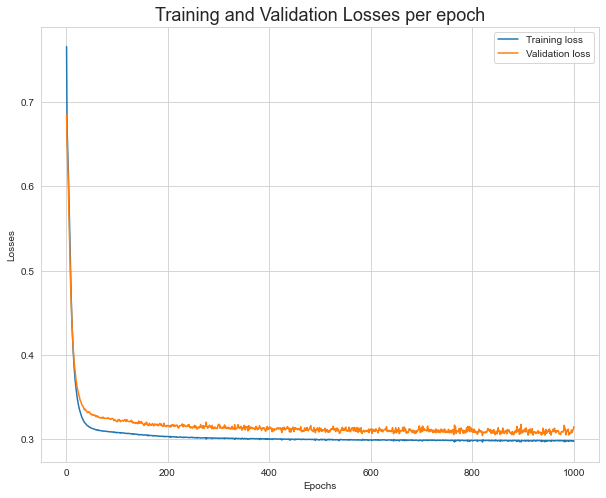

In [20]:
# Plotting the training and validation losses per epoch
fig = plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

sns.lineplot(x=np.arange(1, len(tl) + 1), y=tl, label="Training loss")
sns.lineplot(x=np.arange(1, len(vl) + 1), y=vl, label="Validation loss")

plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Training and Validation Losses per epoch", fontsize=18)
plt.legend()
plt.show()


The accuracy obtained from the custom NN with learning rate 0.0100 and 5000 epochs is: 97.53%


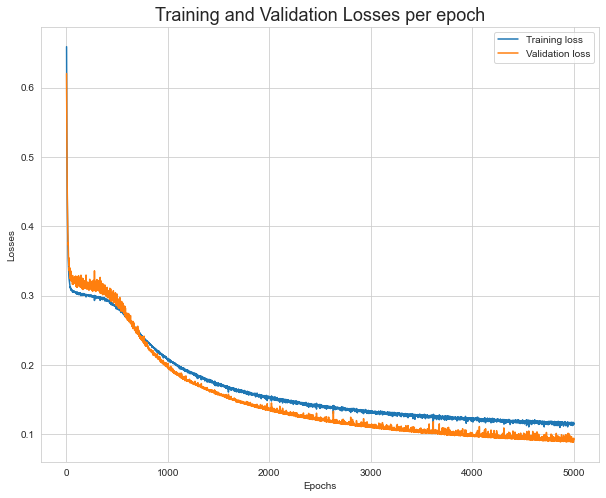

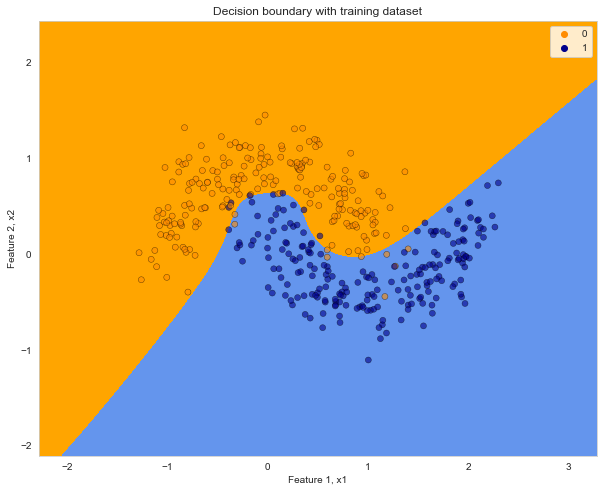

The accuracy obtained from the custom NN with learning rate 0.0100 and 7500 epochs is: 97.53%


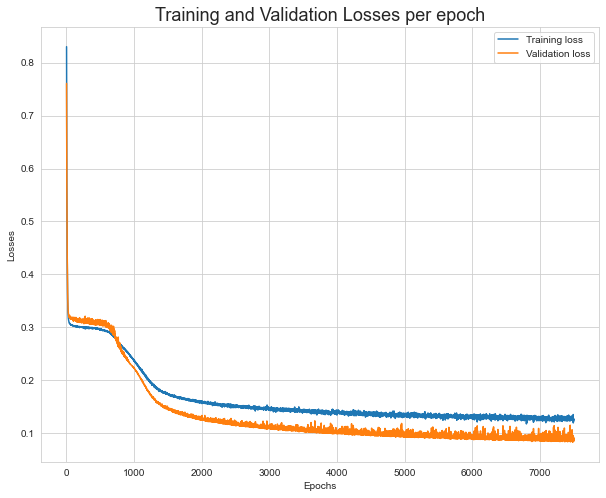

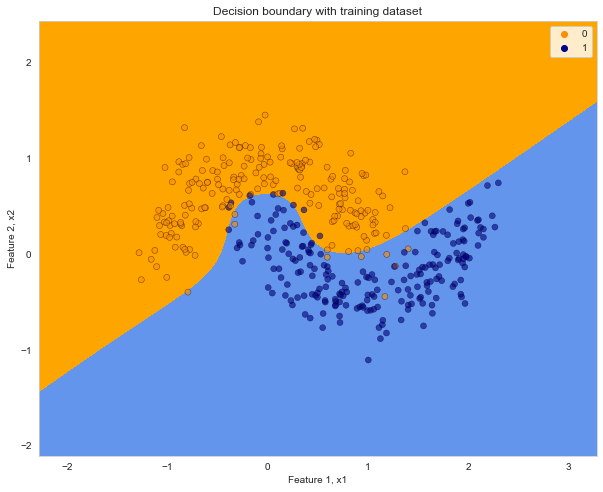

The accuracy obtained from the custom NN with learning rate 0.0070 and 5000 epochs is: 98.77%


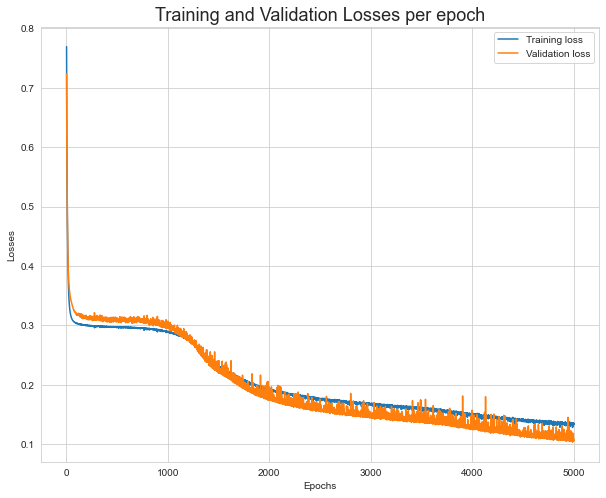

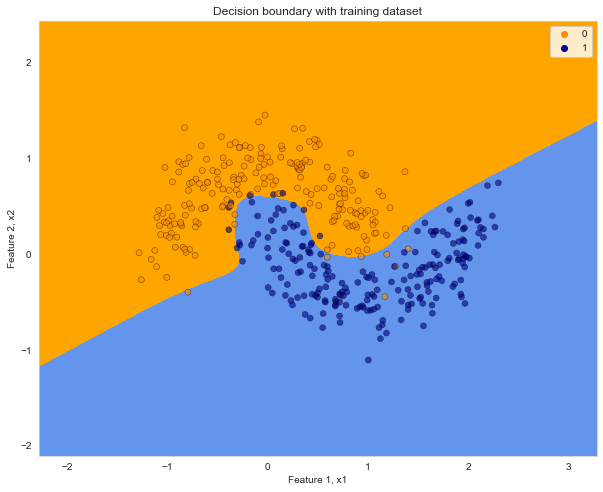

The accuracy obtained from the custom NN with learning rate 0.0070 and 7500 epochs is: 96.30%


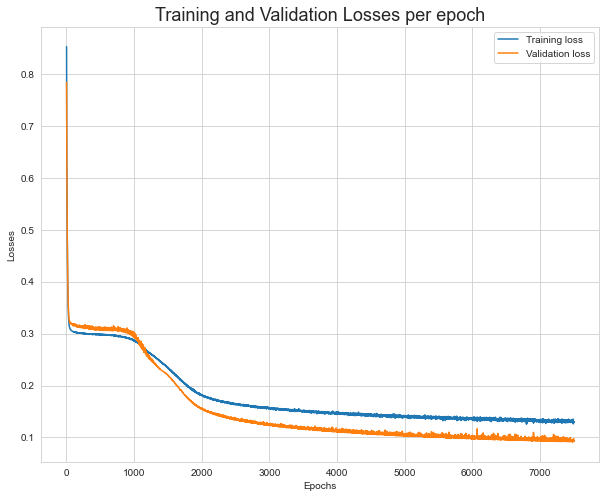

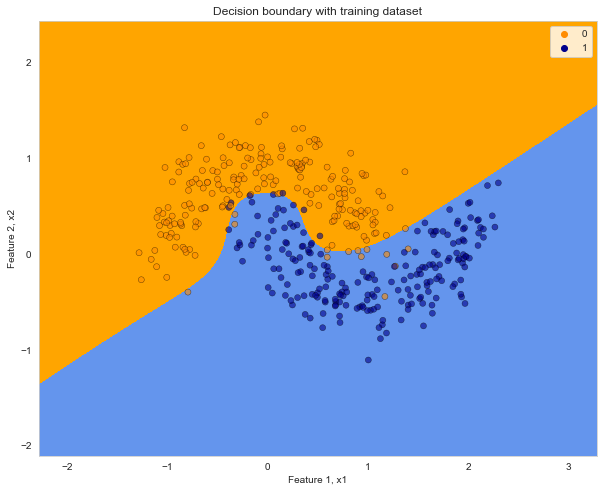

The accuracy obtained from the custom NN with learning rate 0.0030 and 5000 epochs is: 92.59%


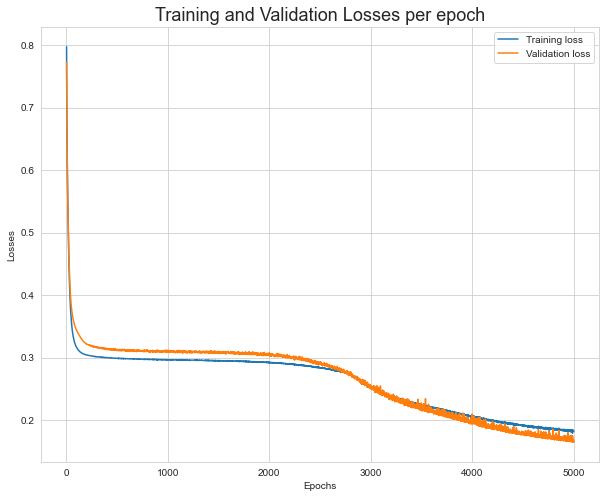

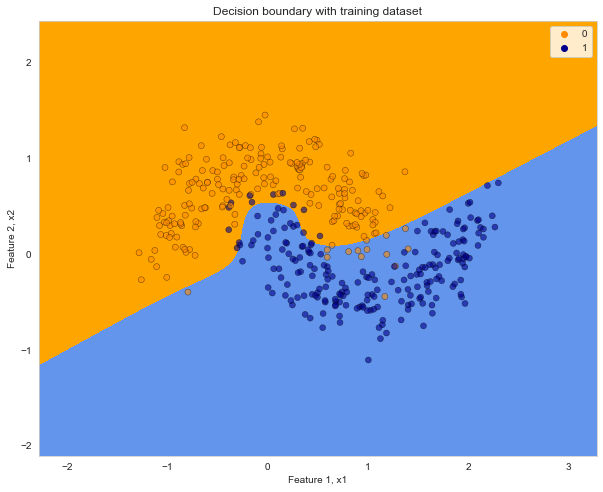

The accuracy obtained from the custom NN with learning rate 0.0030 and 7500 epochs is: 95.06%


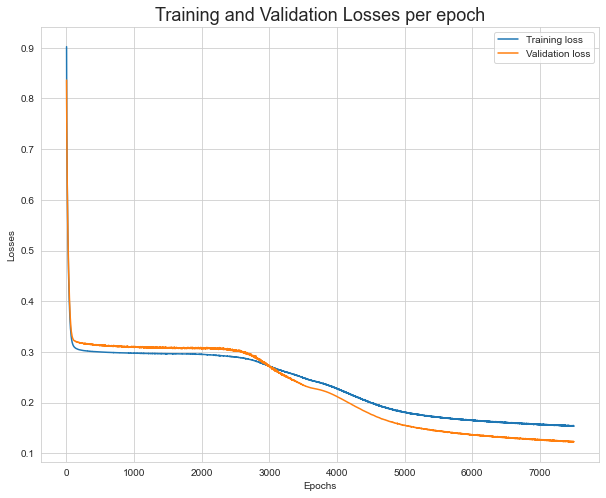

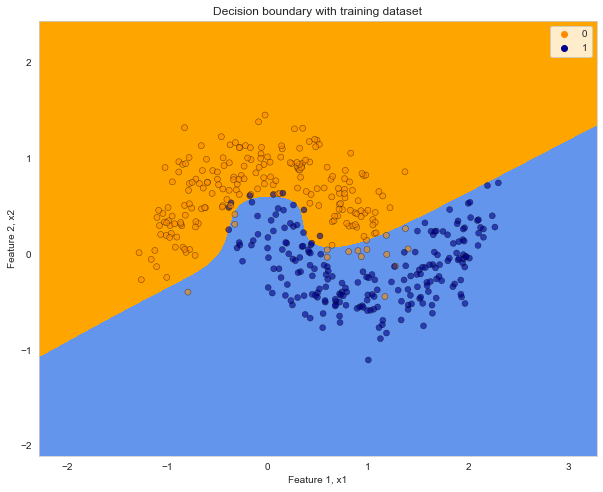

The accuracy obtained from the custom NN with learning rate 0.0010 and 5000 epochs is: 86.42%


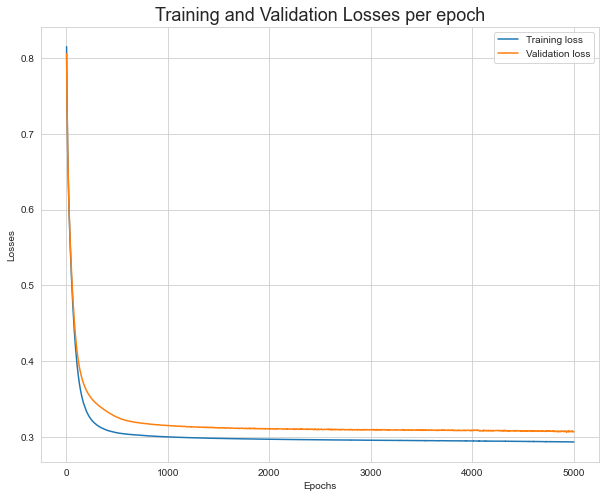

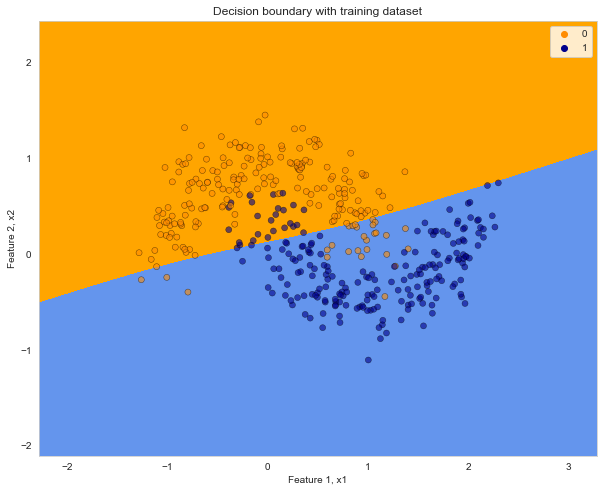

The accuracy obtained from the custom NN with learning rate 0.0010 and 7500 epochs is: 86.42%


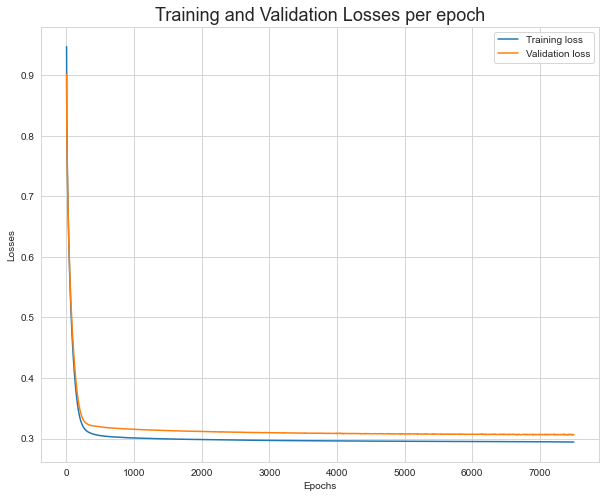

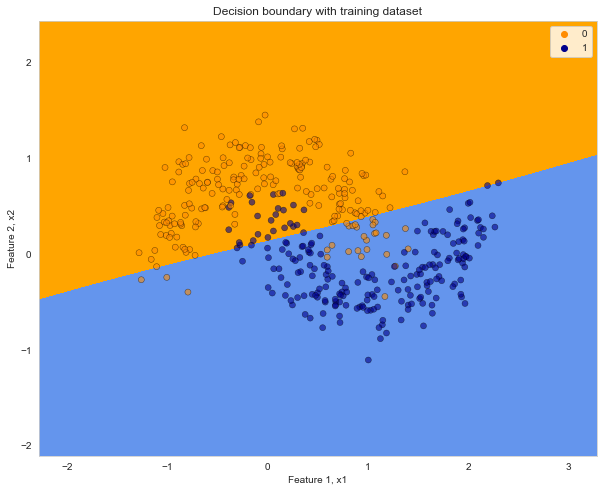

In [21]:
# Tuning custom classifier by varying learning rate and number of epochs

for lr in [0.01, 0.007, 0.003, 0.001]:
    for ep in [5000, 7500]:
        nn = myNeuralNetwork(2, 8, 8, 1, learning_rate=lr)
        tl, vl = nn.fit(
            X_tr,
            y_tr,
            X_val,
            y_val,
            max_epochs=ep,
            get_validation_loss=True,
            verbose=False,
        )
        print(
            "The accuracy obtained from the custom NN with learning rate {:.4f} and {} epochs is: {:.2%}".format(
                lr, ep, prediction_accuracy(nn.predict(X_val), y_val)
            )
        )

        fig = plt.figure(figsize=(10, 8))
        sns.set_style("whitegrid")

        sns.lineplot(x=np.arange(1, len(tl) + 1), y=tl, label="Training loss")
        sns.lineplot(x=np.arange(1, len(vl) + 1), y=vl, label="Validation loss")

        plt.xlabel("Epochs")
        plt.ylabel("Losses")
        plt.title("Training and Validation Losses per epoch", fontsize=18)
        plt.legend()
        plt.show()

        # Plotting training and validation data with decision boundary
        h = 0.02  # step size in the mesh

        # Create color maps
        cmap_light = ListedColormap(["orange", "cornflowerblue"])
        cmap_bold = ["darkorange", "darkblue"]

        # Plot the decision boundary. For that, we will assign a color to
        # each point in the mesh [x_min, x_max]x[y_min, y_max].
        x_min, x_max = X_tr[:, 0].min() - 1, X_tr[:, 0].max() + 1
        y_min, y_max = X_tr[:, 1].min() - 1, X_tr[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        Z = nn.predict_proba(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        fig2 = plt.figure(figsize=(10, 8))
        sns.set_style("whitegrid")

        Z = np.array(Z).reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=cmap_light)

        # Plot also the training points
        sns.scatterplot(
            x=X_tr[:, 0],
            y=X_tr[:, 1],
            hue=y_tr,
            palette=cmap_bold,
            alpha=0.6,
            edgecolor="black"
            # ax=axes[c-1]
        )
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xlabel("Feature 1, x1")
        plt.ylabel("Feature 2, x2")
        plt.title("Decision boundary with training dataset")
        plt.show()


*As can be observed from the iterations above, setting a learning rate of 0.007 and running for 5000 epochs leads to the best accuarcy obtained on the validation dataset. We now use these parameters to implement our custom neural network.*

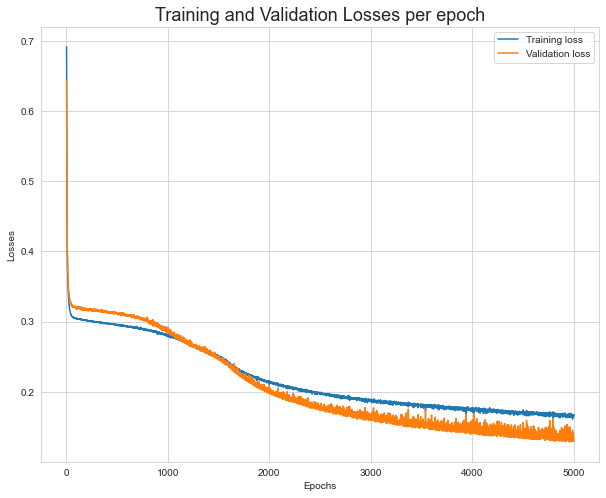

In [23]:
# Fitting the custom classifier with the tuned parameters
nn = myNeuralNetwork(2, 8, 8, 1, learning_rate=0.007)
tl, vl = nn.fit(
    X_tr,
    y_tr,
    X_val,
    y_val,
    max_epochs=5000,
    get_validation_loss=True,
    verbose=False,
)

fig = plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

sns.lineplot(x=np.arange(1, len(tl) + 1), y=tl, label="Training loss")
sns.lineplot(x=np.arange(1, len(vl) + 1), y=vl, label="Validation loss")

plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Training and Validation Losses per epoch", fontsize=18)
plt.legend()
plt.show()


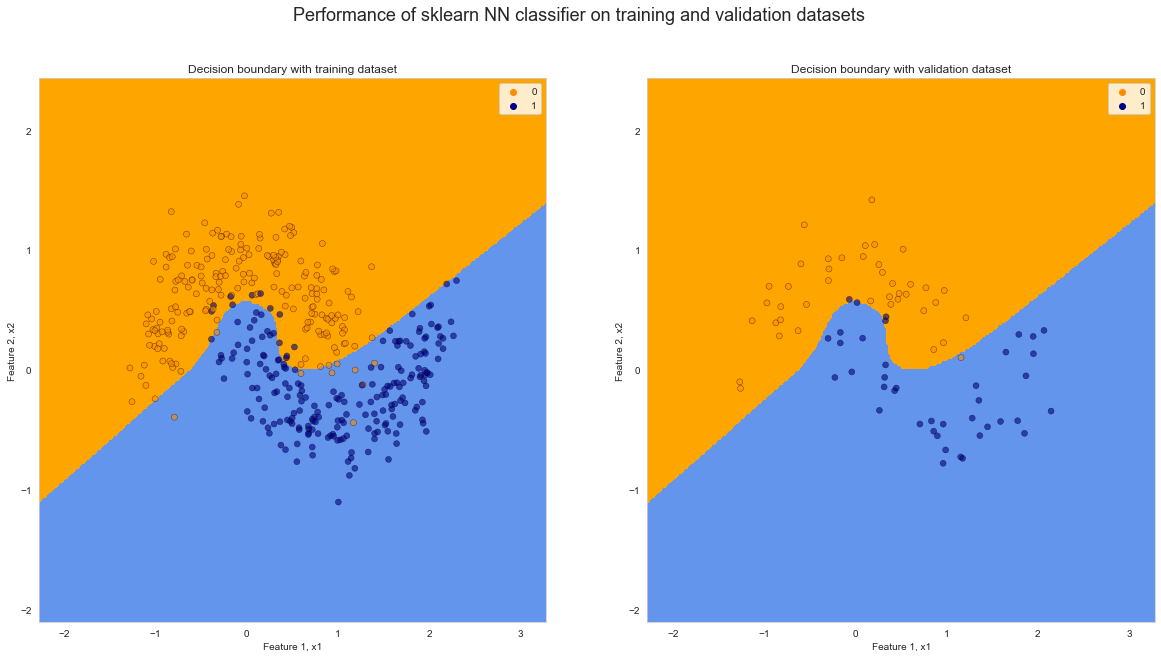

In [24]:
# Plotting training and validation data with decision boundary
h = 0.02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(["orange", "cornflowerblue"])
cmap_bold = ["darkorange", "darkblue"]
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))
c = 1

# Plot the decision boundary. For that, we will assign a color to
# each point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X_tr[:, 0].min() - 1, X_tr[:, 0].max() + 1
y_min, y_max = X_tr[:, 1].min() - 1, X_tr[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = nn.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = np.array(Z).reshape(xx.shape)
plt.subplot(1, 2, c)
plt.contourf(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
sns.scatterplot(
    x=X_tr[:, 0],
    y=X_tr[:, 1],
    hue=y_tr,
    palette=cmap_bold,
    alpha=0.6,
    edgecolor="black"
    # ax=axes[c-1]
)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
# plt.title(
#     "MLP with hidden layer = (%i, %i)" % hl
# )
plt.xlabel("Feature 1, x1")
plt.ylabel("Feature 2, x2")
plt.title("Decision boundary with training dataset")
c += 1

plt.subplot(1, 2, c)
plt.contourf(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
sns.scatterplot(
    x=X_val[:, 0],
    y=X_val[:, 1],
    hue=y_val,
    palette=cmap_bold,
    alpha=0.6,
    edgecolor="black"
    # ax=axes[c-1]
)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel("Feature 1, x1")
plt.ylabel("Feature 2, x2")
plt.title("Decision boundary with validation dataset")

plt.suptitle(
    "Performance of sklearn NN classifier on training and validation datasets",
    fontsize=18,
)

plt.show()


The accuracy of the custom classifier on the test dataset is :96.00%


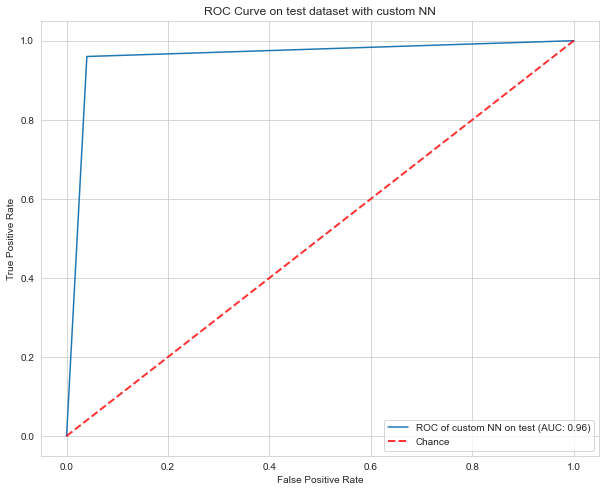

In [25]:
# Checking performance of the custom classifier on test dataset
print(
    "The accuracy of the custom classifier on the test dataset is :{:.2%}".format(
        prediction_accuracy(nn.predict(X_test), y_test)
    )
)

y_pred = nn.predict(X_test)

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
sns.lineplot(
    x=fpr, y=tpr, label="ROC of custom NN on test (AUC: " + str(round(roc_auc, 3)) + ")"
)
sns.lineplot(
    x=[0, 1], y=[0, 1], label="Chance", linestyle="--", lw=2, color="r", alpha=0.8
)
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on test dataset with custom NN")
plt.show()


In [29]:
# fitting the MLP classifier from sklearn
clf = MLPClassifier(
    learning_rate_init=0.007,
    hidden_layer_sizes=(8, 8),
    alpha=0,
    solver="sgd",
    tol=0,
    early_stopping=True,
    validation_fraction=0.2,
    activation="logistic",
    n_iter_no_change=5000,
    batch_size=1,
    max_iter=5000,
    learning_rate="constant",
    # verbose=True,
    momentum=0,
).fit(X_train, y_train)


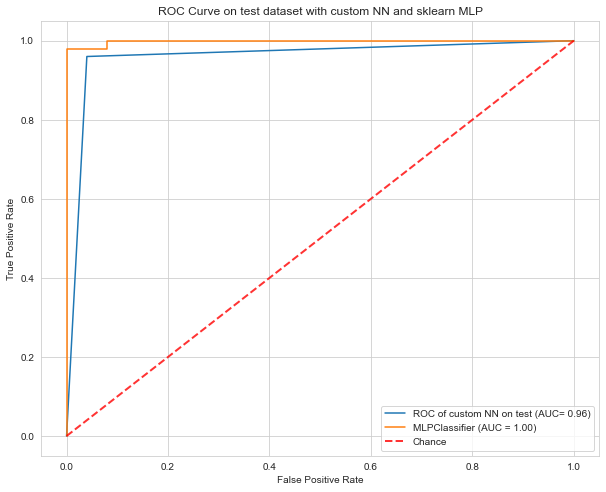

In [30]:
clf_preds_test = clf.predict(X_test)

fpr_sk, tpr_sk, __ = roc_curve(y_test, clf_preds_test)
roc_auc_sk = auc(fpr_sk, tpr_sk)

fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(
    x=fpr,
    y=tpr,
    ax=ax,
    label="ROC of custom NN on test (AUC= " + str(round(roc_auc, 3)) + ")",
)
plot_roc_curve(clf, X_test, y_test, ax=ax)
sns.lineplot(
    x=[0, 1], y=[0, 1], label="Chance", linestyle="--", lw=2, color="r", alpha=0.8
)
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on test dataset with custom NN and sklearn MLP")
plt.show()

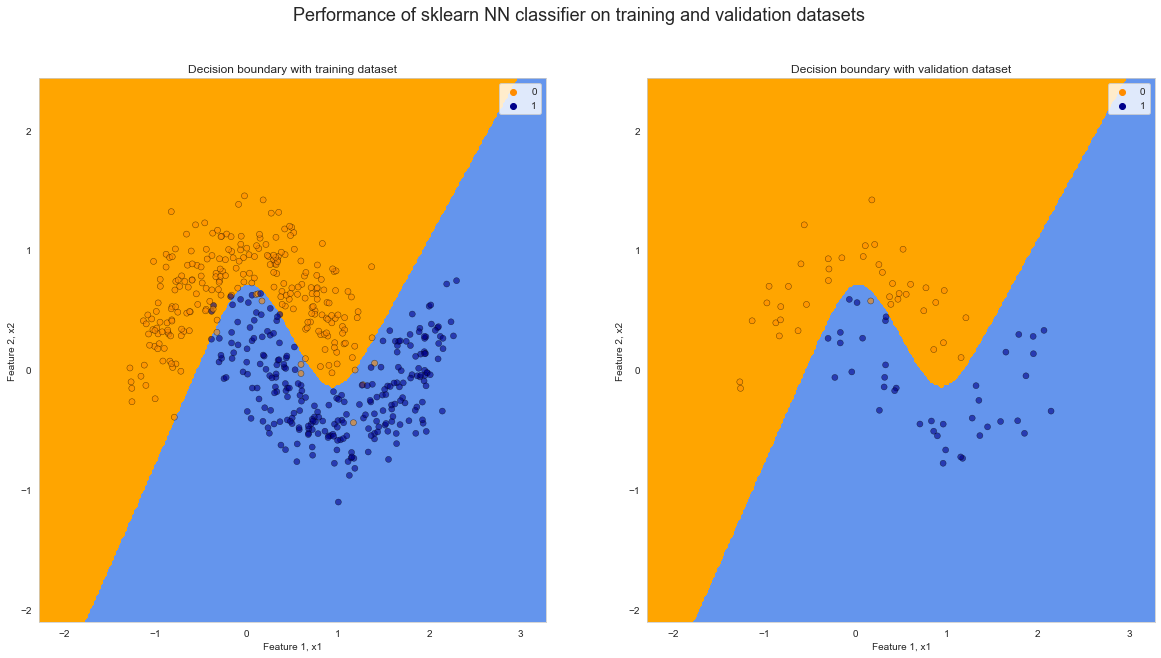

In [31]:
# Plotting training and validation data with decision boundary
h = 0.02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(["orange", "cornflowerblue"])
cmap_bold = ["darkorange", "darkblue"]
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))
c = 1

# Plot the decision boundary. For that, we will assign a color to
# each point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = np.array(Z).reshape(xx.shape)
plt.subplot(1, 2, c)
plt.contourf(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
sns.scatterplot(
    x=X_train[:, 0],
    y=X_train[:, 1],
    hue=y_train,
    palette=cmap_bold,
    alpha=0.6,
    edgecolor="black"
    # ax=axes[c-1]
)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
# plt.title(
#     "MLP with hidden layer = (%i, %i)" % hl
# )
plt.xlabel("Feature 1, x1")
plt.ylabel("Feature 2, x2")
plt.title("Decision boundary with training dataset")
c += 1

plt.subplot(1, 2, c)
plt.contourf(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
sns.scatterplot(
    x=X_val[:, 0],
    y=X_val[:, 1],
    hue=y_val,
    palette=cmap_bold,
    alpha=0.6,
    edgecolor="black"
    # ax=axes[c-1]
)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel("Feature 1, x1")
plt.ylabel("Feature 2, x2")
plt.title("Decision boundary with validation dataset")

plt.suptitle(
    "Performance of sklearn NN classifier on training and validation datasets",
    fontsize=18,
)

plt.show()


**ANSWER**

**(c)**

The custom neural network does not implement regularization. It can be observed that while running for a higher number of epochs, the decision boundary tends to get more skewed towards the blue dots, which is a sign of overfitting. Regularization can help address this issue. Another way to improve the network would be to implement momentum. This can help the network find a local or global minimum faster than with only a constant learning rate, as it adds an extra step in the gradient in the direction of descent.